In [1]:
#
# notebook config
#

# dataset generation
DIM_FROM    = 3
DIM_TO      = 2
REM_DIM     = 1
TOTAL_VECS  = 10000
SPLITS      = [ 0.8, 0.2, 0.2 ]

# training parameters
BATCH_SIZE  = 20
LEARNING_RATE = 1.0
GAMMA       =0.7
MAX_EPOCHS  = 10

# random seed for reproducibility
SEED        = 42

# architecture search experiment results (optional)
CSV = "data/projection_architecture_search.csv" 

In [2]:
#
# imports
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary



In [3]:
#
# require some package versions going forward
#
print("Checking pytorch version...")
if int(torch.version.__version__.split('.')[0])==2:
    print("Pytorch version at %s is ok. " % torch.version.__version__)
else:
    raise Exception("Pytorch version check failed.")

Checking pytorch version...
Pytorch version at 2.0.0 is ok. 


In [4]:
# 
# define a simple linear model
#
class Linear1(nn.Module):
    '''Define a 1-layer neural network, no drop out, no activation'''
    def __init__(self):
        super(Linear1, self).__init__()
        self.fc = nn.Linear(DIM_FROM, DIM_TO)
    def forward(self, x):
        output = self.fc(x)
        return output


In [5]:
#
# create a numpy dataset
#
dset_in = np.random.rand( TOTAL_VECS, DIM_FROM )
dset_out = np.array( [ np.array( list(el[0:REM_DIM]) + list(el[REM_DIM+1:]) ) for el in dset_in ] )
# sanity check
print("dataset sanity check...")
print(dset_in.shape, dset_in.dtype, dset_in[0].dtype)
print(dset_out.shape, dset_out.dtype, dset_out[0].dtype)
print(dset_in[0], dset_out[0])
print(dset_in[-1], dset_out[-1])



dataset sanity check...
(10000, 3) float64 float64
(10000, 2) float64 float64
[0.76492766 0.00994853 0.32035357] [0.76492766 0.32035357]
[0.28006788 0.70961775 0.0098974 ] [0.28006788 0.0098974 ]


In [6]:
#
# use scikit for splitting into training/validation/test
#
x_train, x_test, y_train, y_test = train_test_split(dset_in, dset_out, test_size=SPLITS[1]+SPLITS[2])
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=SPLITS[2]/(SPLITS[1]+SPLITS[2]))
# sanity check
print("tr/val/test split sanity check:", x_train.shape, x_val.shape, x_test.shape)


tr/val/test split sanity check: (6000, 3) (2000, 3) (2000, 3)


In [7]:
#
# create model and summarize
#

model = Linear1().to("cpu")
print("model topology:")
print(model)
print()
print("model details:")
summary(model,(1,3))

model topology:
Linear1(
  (fc): Linear(in_features=3, out_features=2, bias=True)
)

model details:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 2]               8
Total params: 8
Trainable params: 8
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [8]:
#
# coax numpy dataset into Pytorch tensors
#
x_train_tensors = torch.Tensor(x_train)
y_train_tensors = torch.Tensor(y_train)
train_tensors = TensorDataset(x_train_tensors,y_train_tensors)

x_validate_tensors = torch.Tensor(x_val)
y_validate_tensors = torch.Tensor(y_val)
validate_tensors = TensorDataset(x_validate_tensors,y_validate_tensors)

x_test_tensors = torch.Tensor(x_test)
y_test_tensors = torch.Tensor(y_test)
test_tensors = TensorDataset(x_test_tensors,y_test_tensors)


In [9]:
#
# create Pytorch batch loaders
#
train_loader = DataLoader(train_tensors,batch_size=BATCH_SIZE )
validate_loader = torch.utils.data.DataLoader(validate_tensors, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_tensors, batch_size=BATCH_SIZE)


In [10]:
#
# define what happens in a training step
#
def train(model, device, train_loader, optimizer, epoch):
    '''Define the train function'''
    model.train()
    training_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    training_loss /= len(train_loader.dataset)
    return training_loss


In [11]:
#
# define what happens in a validation step
#
def validate(model, device, validate_loader):
    '''Define the validation function'''
    model.eval() 
    validate_loss = 0
    with torch.no_grad():
        for data, target in validate_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validate_loss += F.mse_loss(output, target, reduction='sum').item()  # sum up batch loss

    validate_loss /= len(validate_loader.dataset)
    return validate_loss


In [12]:
#
# prepare the training optimizer
#
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)



Traing: epoch=1: train loss=0.002343093434038 validation loss=0.025866736
Traing: epoch=2: train loss=0.000251638059019 validation loss=0.001659516
Traing: epoch=3: train loss=0.000008728952808 validation loss=0.000000368
Traing: epoch=4: train loss=0.000000000895095 validation loss=0.000000000
Traing: epoch=5: train loss=0.000000000000073 validation loss=0.000000000
Traing: epoch=6: train loss=0.000000000000001 validation loss=0.000000000
Traing: epoch=7: train loss=0.000000000000001 validation loss=0.000000000
Traing: epoch=8: train loss=0.000000000000001 validation loss=0.000000000
Traing: epoch=9: train loss=0.000000000000001 validation loss=0.000000000
Traing: epoch=10: train loss=0.000000000000001 validation loss=0.000000000


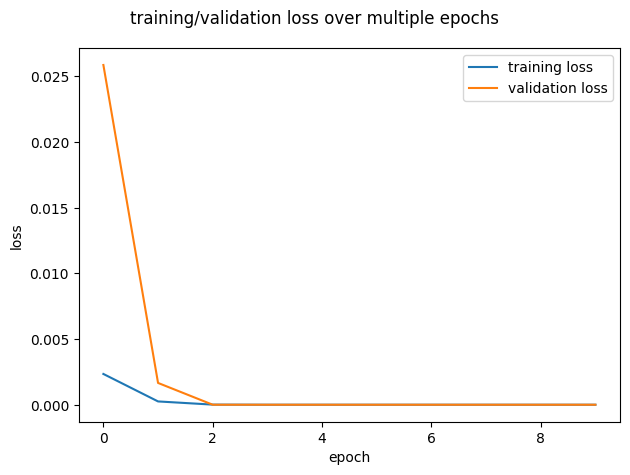

In [13]:
# 
# train (tracking training and validation loss)
# 
tlosses = []
vlosses = []

for epoch in range(1, MAX_EPOCHS + 1):
    tloss = train(model, "cpu", train_loader, optimizer, epoch)
    vloss = validate(model, "cpu", validate_loader)
    print("Traing: epoch=%d: train loss=%.15f validation loss=%.9f" % (epoch, tloss, vloss) )
    scheduler.step()
    tlosses.append(tloss)
    vlosses.append(vloss)

plt.plot(tlosses, label='training loss')
plt.plot(vlosses, label='validation loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.suptitle("training/validation loss over multiple epochs")
plt.tight_layout()

In [14]:
#
# sanity check the trained model on test set
#
print('{: <10}{: <40}{: <40}{: <20}'.format("model", "input", "target", "prediction" ))

model.eval()
with torch.no_grad():

    # just get the one batch of input, target pairs
    data, target = next(iter(test_loader))

    # get predictions
    print(type(data),data.shape)
    output = model(data)

    # print predictions and compare to 'target' ground truth
    for b in range(len(data)):
        print('{: <10}{: <40}{: <40}{: <20}'.format(\
            model.__class__.__name__, str(data[b]), str(target[b]), str(output[b])))


model     input                                   target                                  prediction          
<class 'torch.Tensor'> torch.Size([20, 3])
Linear1   tensor([0.9714, 0.5905, 0.3234])        tensor([0.9714, 0.3234])                tensor([0.9714, 0.3234])
Linear1   tensor([0.8619, 0.5797, 0.2676])        tensor([0.8619, 0.2676])                tensor([0.8619, 0.2676])
Linear1   tensor([0.7873, 0.4035, 0.5977])        tensor([0.7873, 0.5977])                tensor([0.7873, 0.5977])
Linear1   tensor([0.6725, 0.5240, 0.1931])        tensor([0.6725, 0.1931])                tensor([0.6725, 0.1931])
Linear1   tensor([0.5665, 0.0666, 0.8864])        tensor([0.5665, 0.8864])                tensor([0.5665, 0.8864])
Linear1   tensor([0.3121, 0.0541, 0.1312])        tensor([0.3121, 0.1312])                tensor([0.3121, 0.1312])
Linear1   tensor([0.3914, 0.9692, 0.2857])        tensor([0.3914, 0.2857])                tensor([0.3914, 0.2857])
Linear1   tensor([0.2617, 0.3092, 0.8865]

In [15]:
#
# sanity check with manual input applied as input to the trained model
#

# manually create a Pytorch tensor from a numpy array
manual_np_arr = np.array([[0.21, 0.77, 0.98]],dtype=np.float32)
manual_pytorch_tensor = torch.from_numpy( manual_np_arr )

print('{: <10}{: <40}{: <20}'.format("model", "input", "prediction" ))
model.eval()
with torch.no_grad():
     # get prediction from the model on this input
    output = model(manual_pytorch_tensor)

    # print prediction
    print('{: <10}{: <40}{: <20}'.format(\
            model.__class__.__name__, str(manual_pytorch_tensor[0]), str(output[0])))

model     input                                   prediction          
Linear1   tensor([0.2100, 0.7700, 0.9800])        tensor([0.2100, 0.9800])


In [16]:
#
# let's look at the trained weights
#
torch.set_printoptions(precision=1)
print(model.fc.weight)

# it should look something like
# [ 1 0 0 
#   0 0 1 ]
# which indicates the network has learned something akin to identity with a column removed

Parameter containing:
tensor([[ 1.0e+00,  2.6e-08, -2.7e-08],
        [-5.3e-09,  8.8e-09,  1.0e+00]], requires_grad=True)


In [17]:
#
# In this part of the notebook, we analyze an exhaustive
# architecture search with different basic architectures
# including non-linear activations, dropout, and multiple layers
# and training hyperparameters like learning rate, gamma, training epochs and
# batch size
#

In [18]:
#
# load architecture search data
#
df = pd.read_csv(CSV,delimiter='\t')
df.head(10)

,Unnamed: 0,model,mparms,trsamples,bsize,lr,gamma,maxepochs,avgtestloss
0,0,Linear1,(),600,10,0.5,0.3,10,1.306716e-01
1,1,Linear1,(),600,10,0.5,0.3,100,1.306713e-01
2,2,Linear1,(),600,10,0.5,0.3,250,1.306713e-01
3,3,Linear1,(),600,10,0.5,0.7,10,4.572844e-02
4,4,Linear1,(),600,10,0.5,0.7,100,4.402199e-02
5,5,Linear1,(),600,10,0.5,0.7,250,4.402199e-02
6,6,Linear1,(),600,10,1.0,0.3,10,9.200741e-03
7,7,Linear1,(),600,10,1.0,0.3,100,9.200667e-03
8,8,Linear1,(),600,10,1.0,0.3,250,9.200667e-03
9,9,Linear1,(),600,10,1.0,0.7,10,9.298249e-08


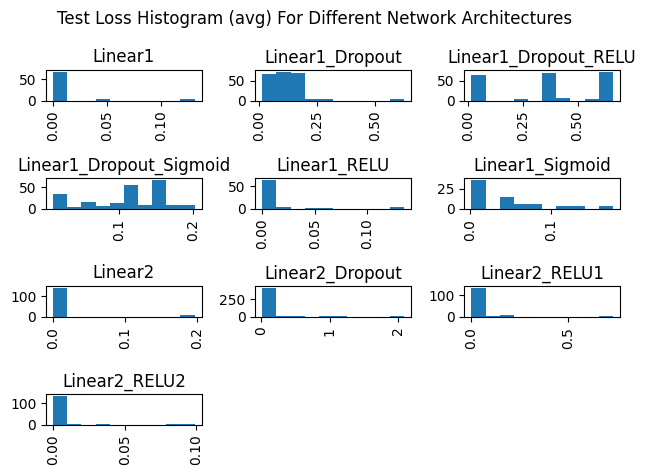

In [19]:
#
# histogram the final validation loss
#
df.hist('avgtestloss', by='model')
plt.suptitle("Test Loss Histogram (avg) For Different Network Architectures")
plt.tight_layout()

In [20]:
#
# Linear1 looks good, lets explore further
#
pd.set_option('display.float_format', '{:.10f}'.format)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
df[ df['model']=='Linear1' ]

,Unnamed: 0,model,mparms,trsamples,bsize,lr,gamma,maxepochs,avgtestloss
0,0,Linear1,(),600,10,0.5000000000,0.3000000000,10,0.1306716055
1,1,Linear1,(),600,10,0.5000000000,0.3000000000,100,0.1306713116
2,2,Linear1,(),600,10,0.5000000000,0.3000000000,250,0.1306713116
3,3,Linear1,(),600,10,0.5000000000,0.7000000000,10,0.0457284376
4,4,Linear1,(),600,10,0.5000000000,0.7000000000,100,0.0440219861
5,5,Linear1,(),600,10,0.5000000000,0.7000000000,250,0.0440219861
6,6,Linear1,(),600,10,1.0000000000,0.3000000000,10,0.0092007408
7,7,Linear1,(),600,10,1.0000000000,0.3000000000,100,0.0092006667
8,8,Linear1,(),600,10,1.0000000000,0.3000000000,250,0.0092006667
9,9,Linear1,(),600,10,1.0000000000,0.7000000000,10,0.0000000930
